In [6]:
import PIL.Image
import numpy as np
import pylab as py
import cv2
from PIL import Image
import sklearn.decomposition

#change n components less than 768 --30

In [7]:
#grabs frames
vidcap = cv2.VideoCapture('bw_nature.avi')
success,image = vidcap.read()
count = 1
success = True
while success:
  cv2.imwrite("Video_images/%d.jpg" % count, image)    
  img = Image.open("Video_images/%d.jpg" % count)
  img = img.resize((512,256))
  img = img.convert('L')
  img.save("Video_images/%d.jpg" % count, optimize=True)
  success, image = vidcap.read()
  count += 1
  if(count > 12):
      break  

In [8]:
def collect_natural_patches(num_patches = 1000000, patch_width = 8):
  """ collects image patches
  the natural images are from a specific folder of 13 .tiff files"""

  max_tries = num_patches * 50
  image_width = 200
  
  img_first_patch = 0 # the first patch number accepted from an image
  img_first_try = 0 # the first attempt to take a patch from the image
  patch_cnt = 0 # number of collected patches
  try_cnt = 0 # number of attempted collected patches
  num_pixels = patch_width * patch_width 

  patch_sample = np.zeros([12,patch_width,patch_width],float)
  patch = np.zeros([num_pixels,num_patches],float)
  
  img_patches = np.zeros([num_pixels,num_patches],float)

  # change the image sampled from
  nat_img_cnt = 1  
  image = PIL.Image.open('Video_images/' + str(nat_img_cnt) + '.jpg')
  image = np.asarray(image, 'double').transpose()  
  # normalizing the image
  image -= image.mean()
  image /= image.std()
      
  # collect the patches
  while patch_cnt < num_patches and try_cnt < max_tries:
    try_cnt += 1  # number of total patches attempted

    if (try_cnt - img_first_try) > max_tries/12 or \
      (patch_cnt - img_first_patch) > num_patches/12:
      # change the image sampled from
      nat_img_cnt += 1
      image = PIL.Image.open('Video_images/' + str(nat_img_cnt) + '.jpg')
      image = np.asarray(image, 'double').transpose() 
      image -= image.mean()
      image /= image.std()
      
      img_first_patch = patch_cnt
      img_first_try = try_cnt
    
      # update on every switch of images
      print (int(100 * float(patch_cnt)/num_patches),' percent complete')

        
    patch_sample = image[10:10+patch_width,10:10+patch_width].copy()
    #line that calls for same patch over time for testing
    patch_std = patch_sample.std()
    
    if patch_std > 0.0: # > 0 to remove blank/uninteresting patches for speed
      # create the patch vector     
      patch = np.reshape(patch_sample, num_pixels)   
      patch = patch - np.mean(patch)         
      img_patches[:,patch_cnt] = patch.copy()
      patch_cnt += 1
  return img_patches
        
patches_mat = collect_natural_patches(num_patches = 100000, patch_width = 8)
print('\nshape of the extracted image patch data:', patches_mat.shape)

8  percent complete
16  percent complete
25  percent complete
33  percent complete
41  percent complete
50  percent complete
58  percent complete
66  percent complete
75  percent complete
83  percent complete
91  percent complete

shape of the extracted image patch data: (64, 100000)


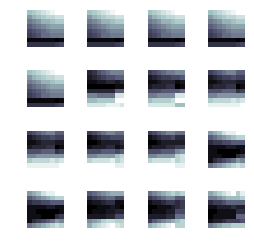

In [4]:
def show_patches_mat(pre_patches, show_patch_num = 16, display=True):
  """ this function generates a 2D array to display image patches (assuming square) """
  
  patches = pre_patches
    
  tot_patches = patches.shape[1]
  data_dim = patches.shape[0]
  patch_width = int(np.round(np.sqrt(data_dim)))
  
  # extract show_patch_num patches
  disp_patch = np.zeros([data_dim, show_patch_num,6], float)
  for i in range(0,show_patch_num):
    patch_i = i * tot_patches // show_patch_num
  
    patch = patches[:,patch_i].copy()
    pmax  = patch.max()
    pmin = patch.min()
    # fix patch range from min to max to 0 to 1
    if pmax > pmin: 
      patch = (patch - pmin) / (pmax - pmin)
    disp_patch[:,i,:] = patch.copy()

  bw = 5    # border width
  pw = patch_width
  
  patches_y = int(np.sqrt(show_patch_num))
  patches_x = int(np.ceil(float(show_patch_num) / patches_y))
  patch_img = disp_patch.max() * np.ones([(pw + bw) * patches_x - bw,
    patches_y * (pw + bw) - bw], float)
  for i in range(0,show_patch_num): 
    y_i = i // patches_y
    x_i = i % patches_y

    reshaped = disp_patch[:,i,:].reshape((pw,pw))
    full_patch = np.zeros([pw, pw,6], float)
    full_patch[0:pw,:] = reshaped[:,:,:].copy()
    patch_img[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = full_patch
    
    if display:
        py.bone()
        py.imshow(patch_img.T, interpolation='nearest')
        py.axis('off')
  return

show_patches_mat(patches_mat)

Quality of image representation using only 40% as much data per patch 
(using only responses along these 25 components instead of the full 64 dimensions): 
 100.00000000000091 %

Percentage of data explained by each filter:
 [8.79344610e+01 9.30042062e+00 1.09436041e+00 7.19793008e-01
 4.53704674e-01 2.22805886e-01 1.62499750e-01 8.39882044e-02
 2.79662707e-02 1.44527193e-07 9.75796180e-29 6.97904950e-29
 4.31057349e-29 1.20729071e-29 6.33016852e-30 1.25590116e-30
 8.77939491e-31 8.77939491e-31 8.77939491e-31 8.77939491e-31
 8.77939491e-31 8.77939491e-31 8.77939491e-31 8.77939491e-31
 8.77939491e-31]


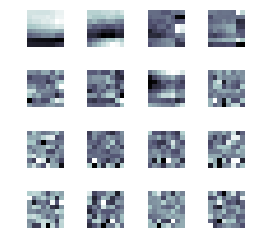

In [9]:
pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patches_mat))

print('Quality of image representation using only 40% as much data per patch',
      '\n(using only responses along these 25 components instead of the full 64 dimensions):',
      '\n',np.sum(100*pcafit.explained_variance_ratio_),'%')

print('\nPercentage of data explained by each filter:\n',100*pcafit.explained_variance_ratio_)

pca_comp = pcafit.components_
show_patches_mat(np.transpose(pca_comp), 16)